In [5]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt

Đường dẫn data

In [6]:
data_original_Path = '../Data/originalData/data_original_new.csv'
data_project_Path = '../Data/originalData/data_project_new.csv'

Đọc file và phân loại

In [7]:
df = pd.read_csv(data_original_Path)  

df['Loại bất động sản'] = df['Phân loại'].apply(lambda x: x.split(' tại ')[0])


Tính tổng giá, tổng số lượng mỗi loại bđs 
--->Tính giá trung bình mỗi loại

In [8]:
def extract_last_price_number(history):
    # Tách các giá trị trong lịch sử, chọn giá trị cuối cùng
    prices = history.split(';')
    
    filtered_prices = [price.strip() for price in prices if price.strip()]

    if filtered_prices:
      last_price = filtered_prices[-1]
    if last_price == 'Không có dữ liệu lịch sử giá':
       return '0'
    
    return last_price.split()[-2].replace(',', '.')
# Thêm cột "Giá cuối cùng" vào DataFrame
df['Giá cuối cùng'] = df['Lịch sử giá'].apply(extract_last_price_number)

# Tạo danh sách các cặp
result = [(row['Loại bất động sản'], row['Giá cuối cùng']) for _, row in df.iterrows()]

total_price = {}
count_classify = {}
avg_price = {}

# Chuyển thành định dạng chuỗi như bạn yêu cầu
for loai_bds, gia_cuoi in result:
    if loai_bds in total_price:
        total_price[loai_bds] += float(gia_cuoi)
        count_classify[loai_bds] += 1
    else:
        total_price[loai_bds] = float(gia_cuoi)
        count_classify[loai_bds] = 1
avg_price = {
    key: (total_price[key] / count_classify[key]) if count_classify[key] > 0 else 0
    for key in total_price.keys()
}



Vẽ biểu đồ cột giá trung bình từng loại hình bất động sản tại Hà Nội

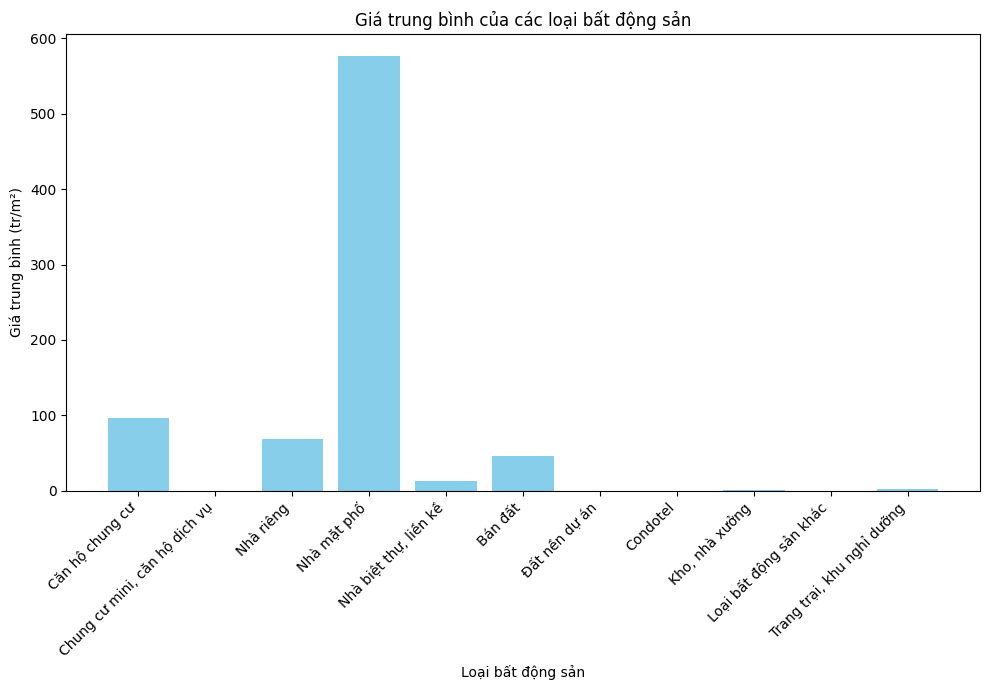

In [9]:
loai_can_ho = list(avg_price.keys())
gia_cac_loai = list(avg_price.values())

# Tạo biểu đồ cột
plt.figure(figsize = (10, 7))  
plt.bar(loai_can_ho, gia_cac_loai, color = 'skyblue')  
plt.xlabel('Loại bất động sản')  
plt.ylabel('Giá trung bình (tr/m²)')  
plt.title('Giá trung bình của các loại bất động sản')  
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()  

# Hiển thị biểu đồ
plt.show()